In [5]:
import json
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import utils

In [27]:
image_ids = [11, 16]
wa_numbers = [0.001, 0.01, 0.1, 1.0, 100.0, 1000.0]

df_cols = ['Wa', "area_fraction", "i_left [A/m2]", "i_right [A/m2]", "stdev_left [A/m2]", "stdev_right [A/m2]", "resistance [ohm.cm2]", "voltage_drop [V]"]

cols = (
    "Wagner number",
    "Contact area fraction at left electrode",
    "Average current density at active area of left electrode [A.m-2]",
    "Average current density at active area of right electrode [A.m-2]",
    "STDEV current density left electrode [A/m2]",
    "STDEV current density right electrode [A/m2]",
    "Total resistance [Ω.cm2]",
    "Voltage drop [V]", 
)

for img_id in image_ids:
    fig, ax = plt.subplots(1, 3, figsize=(15, 4.5))
    dicts = []
    for wa_num in wa_numbers:
        simulation_metafile = os.path.join(f"output/contact_loss_lma/470-470-1/{img_id}/0.5/{wa_num}", "simulation.json")
        f = open(simulation_metafile, "r", encoding='utf-8')
        data = json.load(f)
        f.close()
        val = {}
        for idx, col in enumerate(cols):
            val[df_cols[idx]] = data[col]
        dicts.append(val)
    df = pd.DataFrame(dicts, dtype=float)
    area_fraction = df["area_fraction"][0] * 100
    ax[0].plot(df["Wa"], df["stdev_left [A/m2]"] / df["i_left [A/m2]"])
    ax[0].set_title("Left")
    ax[1].plot(df["Wa"], df["stdev_right [A/m2]"] / df["i_right [A/m2]"])
    ax[1].set_title("Right")
    ax[2].plot(df["Wa"], df["resistance [ohm.cm2]"])
    ax[2].set_title(r"$R_{\Omega}A_0$")
    ax[0].set_xscale('log')
    ax[1].set_xscale('log')
    ax[2].set_xscale('log')
    ax[0].set_xlabel('Wa')
    ax[0].set_ylabel(r'$\frac{\sigma_i}{\mu_i}$', fontsize='xx-large')
    ax[1].set_xlabel('Wa', fontsize='xx-large')
    ax[1].set_ylabel(r'$\frac{\sigma_i}{\mu_i}$', fontsize='xx-large')
    ax[2].set_xlabel('Wa', fontsize='xx-large')
    ax[2].set_ylabel(r'R$_{\mathrm{total}}$' + ' [' + r'$\Omega \mathrm{cm}^2$' + ']', fontsize='xx-large')
    fig.suptitle(r"$\frac{A}{A_0}$" + f' = {area_fraction:.1f}%', fontsize='xx-large')
    plt.tight_layout()
    utils.make_dir_if_missing("figures/contact_loss_lma/kinetics")
    plt.savefig(f'figures/contact_loss_lma/kinetics/{img_id}-1.png');
    plt.close()


In [2]:
area_fractions = {6: 98.41, 11: 36.38, 16: 6.3, 22: 0.45}
max_cd = {1: 65, 5: 25, 15: 25, 30: 25, 50: 25, 100: 25}
norm_current = {
    1: 60,
    5: 15,
    15: 5,
    30: 5,
    50: 5,
    100: 2.5,
}
DIMENSIONS = ['470-470-' + str(v) for v in [1, 5, 15, 30, 50, 100]]
IMAGE_IDS = [6, 11, 16, 22]
AREA_FRACTIONS = [0.01, 0.4, 0.75]

In [3]:
def average_current_density(csv_data_path):
    data = pd.read_csv(csv_data_path)
    i_left = data['vleft [A/m2]'].to_numpy()
    i_right = data['vright [A/m2]'].to_numpy()
    f_left = data['freql'].to_numpy()
    f_right = data['freqr'].to_numpy()
    i_avg = 0.5 * (i_left + i_right)
    i_avg_left = np.dot(f_left, i_left)
    i_avg_right = np.dot(f_right, i_right)
    return i_avg_left, i_avg_right

In [4]:
def drop_leading_and_ending_columns_containing_zero_frequency(arr):
    leading_idx_start = 0
    leading_idx_end = 0
    ending_idx_start = -1
    ending_idx_end = -1
    break_from_leading = False
    
    while not break_from_leading:
        if not np.isclose(arr[leading_idx_end, 1], 0, atol=1e-3):
            break_from_leading = True
            break
        leading_idx_end += 1
    break_from_leading = False
    while not break_from_leading:
        if not np.isclose(arr[ending_idx_start, 1], 0, atol=1e-3):
            break_from_leading = True
            break
        ending_idx_start -= 1
    arr_out = np.zeros((arr.shape[0]+ending_idx_start - leading_idx_end, 2))
    for idx, i in enumerate(range(leading_idx_end, arr.shape[0] + ending_idx_start)):
        arr_out[idx, :] = arr[i, :]
    return arr_out

In [5]:
def i_star(kappa, lz, deltav):
    return kappa * deltav / lz

def get_frequency_csv_path(name_of_study, dimensions, resolution, img_id=None, eps=None):
    if eps is None and img_id is None:
        raise ValueError("Both img_id and eps cannot be `None`.")
    if img_id is None and name_of_study == 'contact_loss_lma':
        raise ValueError(f"img_id cannot be `None` for {name_of_study}")
    if eps is None and name_of_study == 'contact_loss_ref':
        raise ValueError(f"eps cannot be `None` for {name_of_study}")
    if eps is None:
        # return os.path.join('output', name_of_study, dimensions, str(img_id), str(resolution))
        return os.path.join('data', f'frequency-{img_id}-{dimensions.split("-")[2]}.csv')

    return os.path.join('output', name_of_study, str(eps), dimensions, str(resolution), 'frequency.csv')


def get_csv_data(csv_data_path):
    data = pd.read_csv(csv_data_path)
    try:
        arr1 = data[['vleft [A/m2]', 'freql [sq. m]']].to_numpy()
        arr1[:, 1] = arr1[:, 1] / (800e-6 * 800e-6)
        arr2 = data[['vleft [A/m2]', 'freqr [sq. m]']].to_numpy()
        arr2[:, 1] = arr2[:, 1] / (800e-6 * 800e-6)
    except KeyError:
        i_left = data['vleft [A/m2]'].to_numpy()
        i_right = data['vright [A/m2]'].to_numpy()
        f_left = data['freql'].to_numpy()
        f_right = data['freqr'].to_numpy()
        i_mid = 0.5 * (i_left + i_right)
        i_avg_left = np.dot(f_left, i_mid)
        i_avg_right = np.dot(f_right, i_mid)
        arr1 = np.zeros((i_left.shape[0], 2))
        arr2 = np.zeros((i_right.shape[0], 2))
        arr1[:, 0] = 2 * i_mid / i_avg_left
        arr1[:, 1] = f_left
        arr2[:, 0] = 2 * i_mid / i_avg_right
        arr2[:, 1] = f_right
    return arr1, arr2


def make_plot_left(name_of_study, dimensions, resolution=1, img_id=None, eps=None):
    
    if eps is None:
        text_idx = area_fractions[img_id]
        _eps = text_idx
    else:
        text_idx = eps * 100
        _eps = eps * 100
    freq_csv_path = get_frequency_csv_path(name_of_study, dimensions, resolution, img_id, eps)
    data = pd.read_csv(freq_csv_path)
    Lz = int(dimensions.split("-")[2])
    i_min = i_star(kappa=0.1, lz=Lz*(800/470)*1e-6, deltav=1e-3)
    ######
    i_left = data['vleft [A/m2]'].to_numpy()
    i_right = data['vright [A/m2]'].to_numpy()
    try:
        f_left = data['freql'].to_numpy()
    except:
        f_left = data['freql [sq. m]'].to_numpy() / (800e-6 * 800e-6)
    i_mid = 0.5 * (i_left + i_right)
    arr = np.zeros((i_left.shape[0], 2))
    arr[:, 0] = i_mid / i_min
    arr[:, 1] = f_left
    # clean up
    arr = drop_leading_and_ending_columns_containing_zero_frequency(arr)
    fig, ax = plt.subplots()
    ax.plot(arr[:, 0], arr[:, 1], 'bo-', markersize=2.5);
    ax.set_ylabel('frequency')
    ax.set_xlabel(r'$\hat{i}$')
    ax.axhline(y=0, color='k', linestyle='--', linewidth=0.5)
    ax.axvline(x=1, color='k', linestyle='--', linewidth=0.5)
    ax.minorticks_on();
    ax.tick_params(which="both", left=True, right=True, bottom=True, top=True, labelleft=True, labelright=False, labelbottom=True, labeltop=False)
    plt.tight_layout();
    plt.savefig(f'figures/{name_of_study}/frequency-left-{text_idx}-{Lz}.png');
    # plt.close()


def make_plot_right(name_of_study, dimensions, resolution=1, img_id=None, eps=None):
    if eps is None:
        text_idx = area_fractions[img_id]
    else:
        text_idx = eps * 100
    freq_csv_path = get_frequency_csv_path(name_of_study, dimensions, resolution, img_id, eps)
    data = pd.read_csv(freq_csv_path)
    Lz = int(dimensions.split("-")[2])
    i_max = i_star(kappa=0.1, lz=Lz*(800/470)*1e-6, deltav=1e-3)
    ######
    i_left = data['vleft [A/m2]'].to_numpy()
    i_right = data['vright [A/m2]'].to_numpy()
    try:
        f_right = data['freqr'].to_numpy()
    except:
        f_right = data['freqr [sq. m]'].to_numpy() / (800e-6 * 800e-6)
    i_mid = 0.5 * (i_left + i_right)
    arr = np.zeros((i_right.shape[0], 2))
    arr[:, 0] = i_mid / i_max
    arr[:, 1] = f_right
    ######
    # clean up
    arr = drop_leading_and_ending_columns_containing_zero_frequency(arr)
    fig, ax = plt.subplots()
    ax.plot(arr[:, 0], arr[:, 1], 'ro-', markersize=2.5);
    ax.set_ylabel('frequency')
    ax.set_xlabel(r'$\hat{i}$')
    ax.axhline(y=0, color='k', linestyle='--', linewidth=0.5)
    ax.axvline(x=1, color='k', linestyle='--', linewidth=0.5)
    ax.minorticks_on();
    ax.tick_params(which="both", left=True, right=True, bottom=True, top=True, labelleft=True, labelright=False, labelbottom=True, labeltop=False)
    plt.tight_layout()
    plt.savefig(f'figures/{name_of_study}/frequency-right-{text_idx}-{Lz}.png')
    # plt.close()


def moments(name_of_study, dimensions, resolution=1, img_id=None, eps=None):
    freq_csv_path = get_frequency_csv_path(name_of_study, dimensions, resolution, img_id, eps)
    data = pd.read_csv(freq_csv_path)
    avg_val = 0.5 * (data[['vleft [A/m2]']].to_numpy() + data[['vright [A/m2]']].to_numpy())
    try:
        final = np.hstack((avg_val, data[['freql [sq. m]']].to_numpy() / (800e-6 * 800e-6), data[['freqr [sq. m]']].to_numpy() / (800e-6 * 800e-6)))
    except KeyError:
        final = np.hstack((avg_val, data[['freql']].to_numpy(), data[['freqr']].to_numpy()))
    mu_left = np.dot(final[:, 0], final[:, 1])
    mu_right = np.dot(final[:, 0], final[:, 2])
    sd_left = np.sqrt(np.dot((final[:, 0] - mu_left)**2, final[:, 1]))
    sd_right = np.sqrt(np.dot((final[:, 0] - mu_right)**2, final[:, 2]))
    stats = {"mu_left": mu_left, "sd_left": sd_left, "mu_right": mu_right, "sd_right": sd_right}
    return stats, final

### Frequency Distribution of Current Density for Thickness and Active Area Fraction

In [6]:
name_of_study = 'contact_loss_lma'
df = pd.read_csv('data/current-density-zero-right.csv')
df.head(), df.columns

(   Thickness, Lz [um]  Left Active Area, A/A0  Fraction of A0 (i ≈ 0)
 0                 1.7                   36.38                   54.36
 1                 1.7                    6.30                   90.42
 2                 1.7                    0.45                   99.24
 3                85.0                   36.38                    1.00
 4                85.0                    6.30                   22.64,
 Index(['Thickness, Lz [um]', 'Left Active Area, A/A0',
        'Fraction of A0 (i ≈ 0)'],
       dtype='object'))

In [7]:
fig, ax = plt.subplots()
colors = {'r': 1.7, 'b': 85, 'g': 170}
data_arr = np.array(df.to_numpy(), dtype=float)
for c, v in colors.items():
    data = data_arr[np.isclose(data_arr[:, 0], v), :]
    ax.plot(data[:, 1], data[:, 2]/100, color=c, label=f'Lz = {v} ' + r'$\mu m$')
ax.set_xlabel(r'LMA/SSE $\frac{A}{A_0}$ %', fontsize='xx-large')
ax.set_ylabel(r'$\frac{A(i \approx 0)}{A_0}$ %', fontsize='xx-large')
ax.legend()
plt.tight_layout()
plt.savefig(f'figures/current_density_zero_right.png')
plt.close()

In [8]:
name_of_study = 'contact_loss_lma'
utils.make_dir_if_missing(f'figures/{name_of_study}')
moments_data = []
# styles = ['k-', 'r-', 'b-', 'r-.', 'b-.', 'g-'][1:]
styles = ['k-', 'r-', 'b-', 'r-.', 'b-.', 'g-', 'r--', 'b--', 'k-.']
for img_id in IMAGE_IDS:
    # fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    # fig.suptitle(r'$\frac{A}{A_0}$' + f' = {area_fractions[img_id]}%')
    for idx, dimensions in enumerate(['470-470-' + str(v) for v in [1, 15, 30, 100]]):
        Lz = int(dimensions.split("-")[2])
        try:
            stats, final = moments(name_of_study, dimensions, resolution=1, img_id=img_id, eps=None)
        except FileNotFoundError:
            print(f"File not found for {dimensions} and img_id {img_id}")
            continue
        mu_left = stats['mu_left']
        sd_left = stats['sd_left']
        mu_right = stats['mu_right']
        sd_right = stats['sd_right']
        z_left = (final[:, 0] - mu_left) / sd_left
        z_right = (final[:, 0] - mu_right) / sd_right
        moments_data.append((Lz, img_id, mu_left, sd_left, mu_right, sd_right))
#         ax[0].plot(z_left, final[:, 1], styles[idx], label=f'{Lz*800/470:.1f}' + r' $\mu m$')
#         ax[1].plot(z_right, final[:, 2], styles[idx], label=f'{Lz*800/470:.1f}' + r' $\mu m$')
#     ax[0].set_xlim([-3, 3])
#     ax[1].set_xlim([-3, 3])
#     # ax[0].set_ylim([0, 1])
#     # ax[1].set_ylim([0, 1])
#     ax[0].grid(True, which='both');
#     ax[0].minorticks_on();
#     ax[1].grid(True, which='both');
#     ax[1].minorticks_on();
#     ax[0].set_xlabel(r'$\frac{i-\mu_i}{\sigma_i}$', fontsize='xx-large')
#     ax[1].set_xlabel(r'$\frac{i-\mu_i}{\sigma_i}$', fontsize='xx-large')
#     ax[0].set_ylabel('frequency')
#     ax[1].set_ylabel('frequency')
#     # fig.legend(['left', 'right'])
#     ax[0].legend();
#     ax[1].legend();
#     # ax[0].set_yscale('log');
#     # ax[1].set_yscale('log');
#     plt.tight_layout();
#     plt.savefig(f'figures/{name_of_study}/current-density-moments-image-{img_id}.png');
#     # plt.close();


/tmp/ipykernel_413692/3214684398.py:21: RuntimeWarning: divide by zero encountered in divide
  z_right = (final[:, 0] - mu_right) / sd_right
/tmp/ipykernel_413692/3214684398.py:21: RuntimeWarning: invalid value encountered in divide
  z_right = (final[:, 0] - mu_right) / sd_right


In [9]:
df_new = pd.DataFrame(moments_data, columns=['Lz', 'img_id', 'mu_left', 'sd_left', 'mu_right', 'sd_right'])
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
for idx, img_id in enumerate(IMAGE_IDS):
    df_new2 = df_new[df_new['img_id'] == img_id].to_numpy() 
    if idx == 0:
        ax[0, 0].plot(df_new2[:, 0], df_new2[:, 2], label='left')
        ax[0, 0].plot(df_new2[:, 0], df_new2[:, 4], label='right')
        ax[0, 0].set_title(r'$\frac{A}{A_0}$ = ' + f'{area_fractions[img_id]}%')
    elif idx == 1:
        ax[0, 1].plot(df_new2[:, 0], df_new2[:, 2], label='left')
        ax[0, 1].plot(df_new2[:, 0], df_new2[:, 4], label='right')
        ax[0, 1].set_title(r'$\frac{A}{A_0}$ = ' + f'{area_fractions[img_id]}%')
    elif idx == 2:
        ax[1, 0].plot(df_new2[:, 0], df_new2[:, 2], label='left')
        ax[1, 0].plot(df_new2[:, 0], df_new2[:, 4], label='right')
        ax[1, 0].set_title(r'$\frac{A}{A_0}$ = ' + f'{area_fractions[img_id]}%')
    elif idx == 3:
        ax[1, 1].plot(df_new2[:, 0], df_new2[:, 2], label='left')
        ax[1, 1].plot(df_new2[:, 0], df_new2[:, 4], label='right')
        ax[1, 1].set_title(r'$\frac{A}{A_0}$ = ' + f'{area_fractions[img_id]}%')
    else:
        continue
ax[0, 0].set_xlabel('Lz [' + r'$\mu m$]', fontsize='xx-large')
ax[0, 1].set_xlabel('Lz [' + r'$\mu m$]', fontsize='xx-large')
ax[1, 0].set_xlabel('Lz [' + r'$\mu m$]', fontsize='xx-large')
ax[1, 1].set_xlabel('Lz [' + r'$\mu m$]', fontsize='xx-large')

ax[0, 0].set_ylabel(r'$\mu_i$', fontsize='xx-large', rotation='horizontal')
ax[0, 1].set_ylabel(r'$\mu_i$', fontsize='xx-large', rotation='horizontal')
ax[1, 0].set_ylabel(r'$\mu_i$', fontsize='xx-large', rotation='horizontal')
ax[1, 1].set_ylabel(r'$\mu_i$', fontsize='xx-large', rotation='horizontal')
# ax[0, 0].set_yscale('log')
# ax[0, 1].set_yscale('log')
# ax[1, 0].set_yscale('log')
# ax[1, 1].set_yscale('log')
ax[0, 0].legend()
ax[1, 0].legend()
ax[0, 1].legend()
ax[1, 1].legend()
plt.tight_layout()
plt.savefig(f'figures/{name_of_study}/current-density-moments-means.png')
plt.close()

In [10]:
df_new = pd.DataFrame(moments_data, columns=['Lz', 'img_id', 'mu_left', 'sd_left', 'mu_right', 'sd_right'])
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
for idx, img_id in enumerate(IMAGE_IDS):
    df_new2 = df_new[df_new['img_id'] == img_id].to_numpy() 
    if idx == 0:
        ax[0, 0].plot(df_new2[:, 0], df_new2[:, 3] / df_new2[:, 2], label='left')
        ax[0, 0].plot(df_new2[:, 0], df_new2[:, 5] / df_new2[:, 4], label='right')
        ax[0, 0].set_title(r'$\frac{A}{A_0}$ = ' + f'{area_fractions[img_id]}%')
    elif idx == 1:
        ax[0, 1].plot(df_new2[:, 0], df_new2[:, 3] / df_new2[:, 2], label='left')
        ax[0, 1].plot(df_new2[:, 0], df_new2[:, 5] / df_new2[:, 4], label='right')
        ax[0, 1].set_title(r'$\frac{A}{A_0}$ = ' + f'{area_fractions[img_id]}%')
    elif idx == 2:
        ax[1, 0].plot(df_new2[:, 0], df_new2[:, 3] / df_new2[:, 2], label='left')
        ax[1, 0].plot(df_new2[:, 0], df_new2[:, 5] / df_new2[:, 4], label='right')
        ax[1, 0].set_title(r'$\frac{A}{A_0}$ = ' + f'{area_fractions[img_id]}%')
    elif idx == 3:
        ax[1, 1].plot(df_new2[:, 0], df_new2[:, 3] / df_new2[:, 2], label='left')
        ax[1, 1].plot(df_new2[:, 0], df_new2[:, 5] / df_new2[:, 4], label='right')
        ax[1, 1].set_title(r'$\frac{A}{A_0}$ = ' + f'{area_fractions[img_id]}%')
    else:
        continue
ax[0, 0].set_xlabel('Lz [' + r'$\mu m$]', fontsize='xx-large')
ax[0, 1].set_xlabel('Lz [' + r'$\mu m$]', fontsize='xx-large')
ax[1, 0].set_xlabel('Lz [' + r'$\mu m$]', fontsize='xx-large')
ax[1, 1].set_xlabel('Lz [' + r'$\mu m$]', fontsize='xx-large')

ax[0, 0].set_ylabel(r'$\frac{\sigma_i}{\mu_i}$', fontsize='xx-large', rotation='horizontal')
ax[0, 1].set_ylabel(r'$\frac{\sigma_i}{\mu_i}$', fontsize='xx-large', rotation='horizontal')
ax[1, 0].set_ylabel(r'$\frac{\sigma_i}{\mu_i}$', fontsize='xx-large', rotation='horizontal')
ax[1, 1].set_ylabel(r'$\frac{\sigma_i}{\mu_i}$', fontsize='xx-large', rotation='horizontal')

ax[0, 0].legend()
ax[1, 0].legend()
ax[0, 1].legend()
ax[1, 1].legend()
plt.tight_layout()
plt.savefig(f'figures/{name_of_study}/current-density-moments.png')
plt.close()

No file for 470-470-5


/tmp/ipykernel_413692/3485382595.py:67: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()


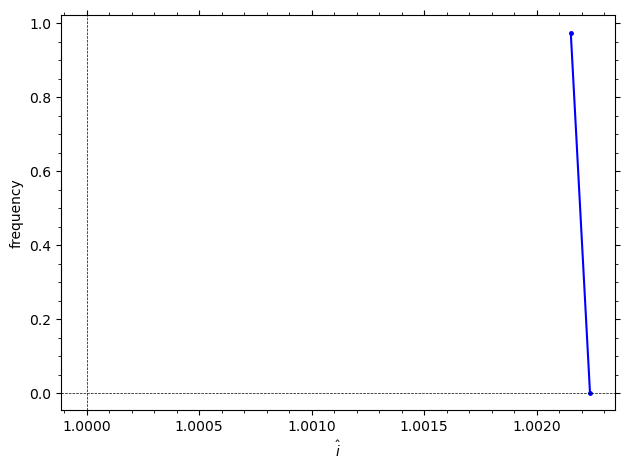

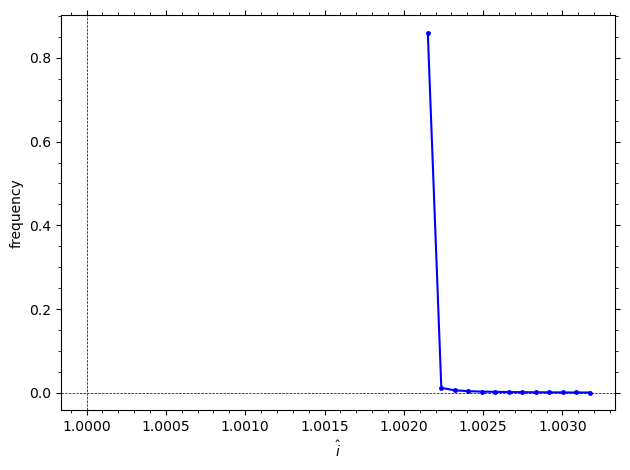

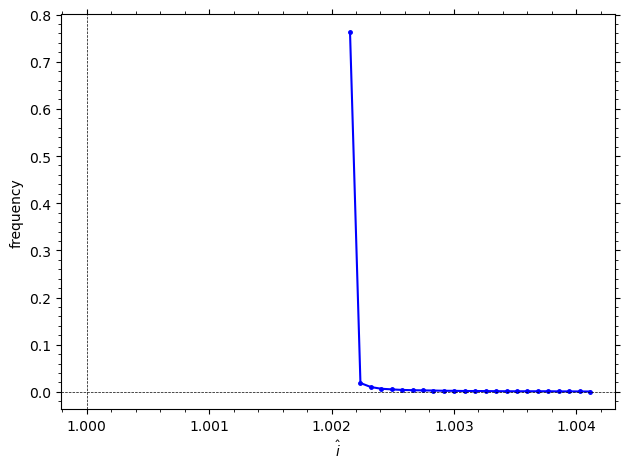

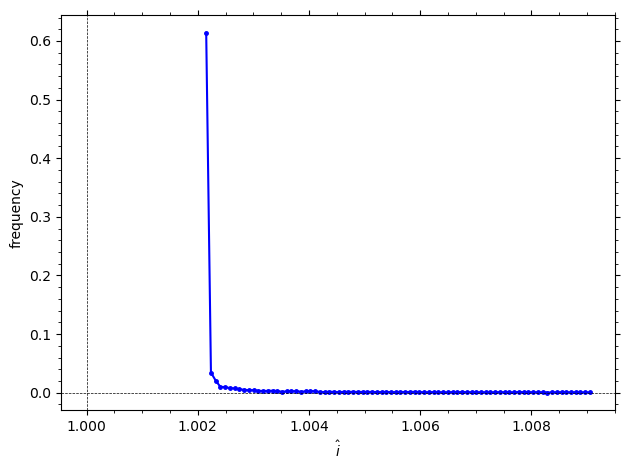

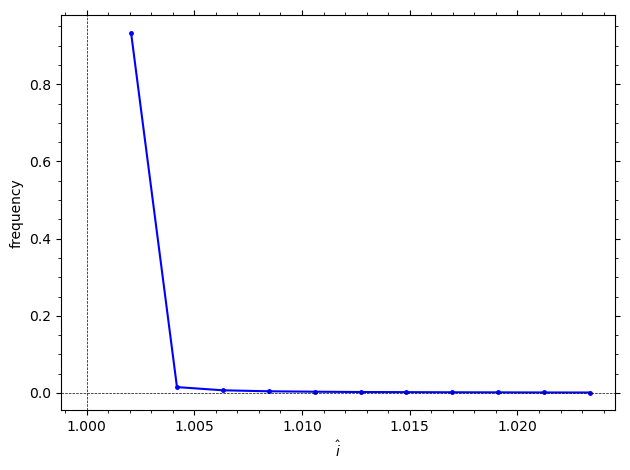

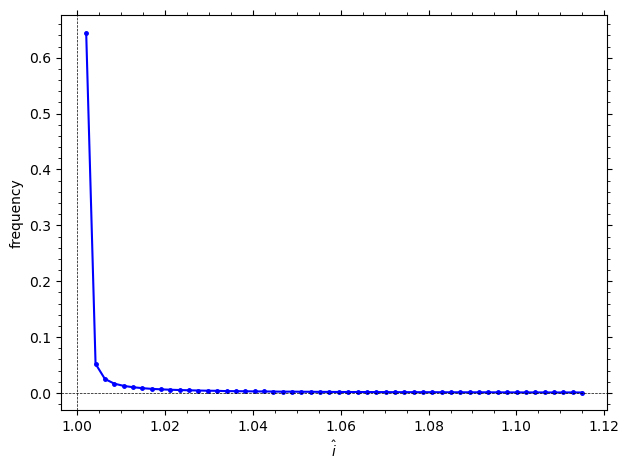

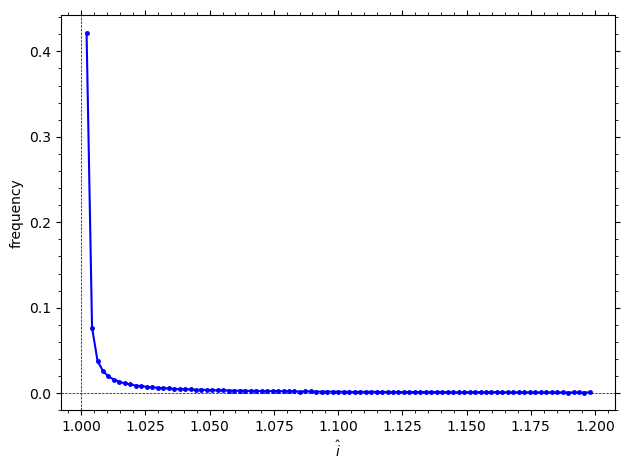

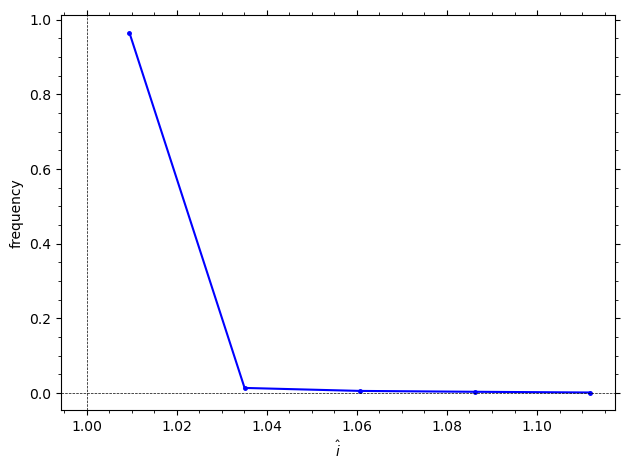

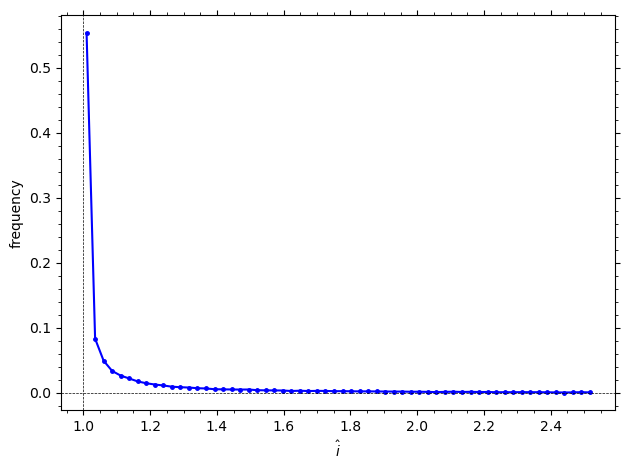

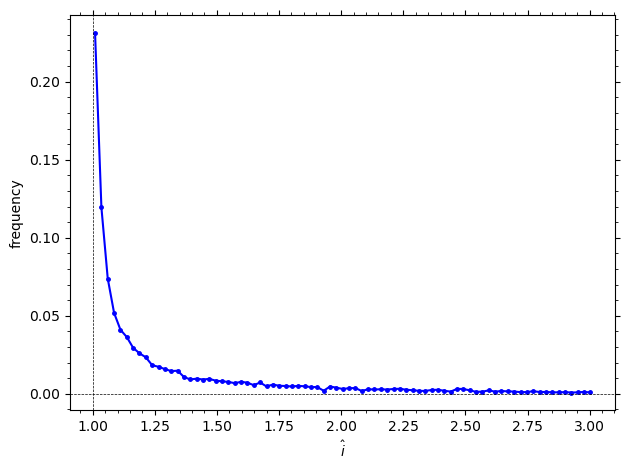

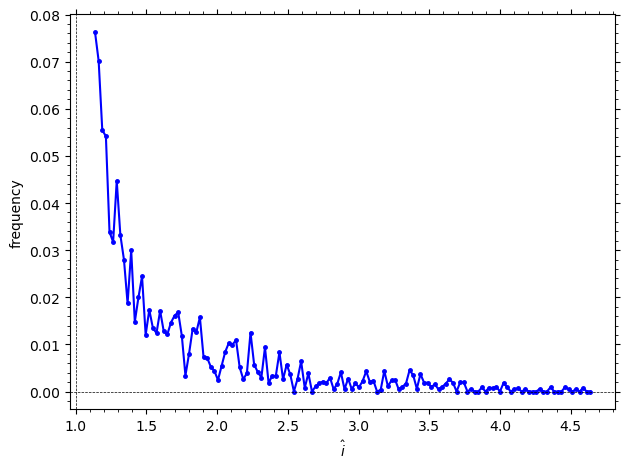

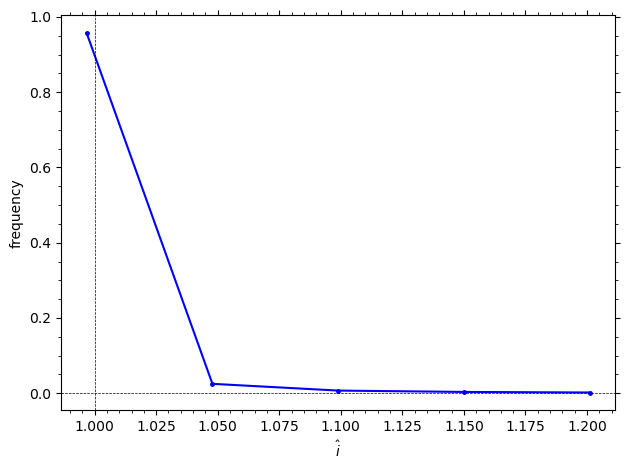

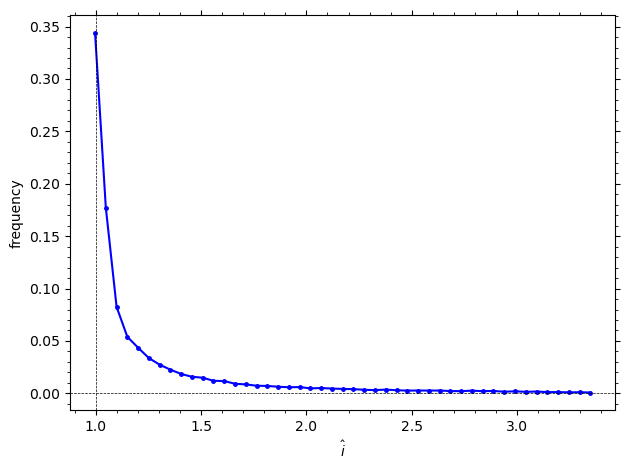

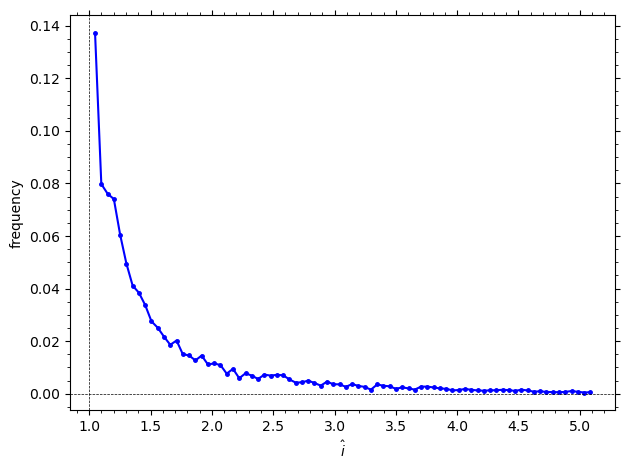

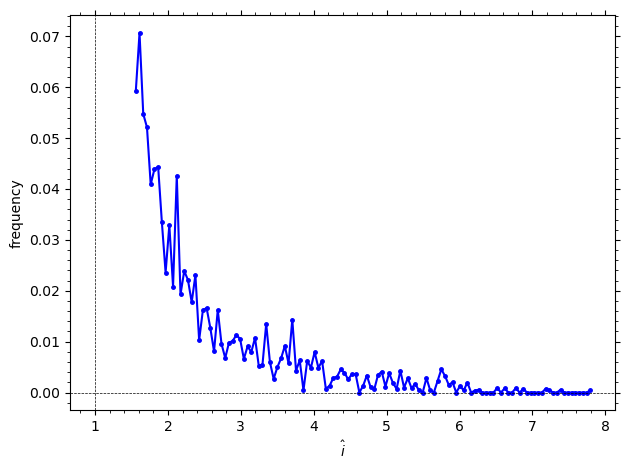

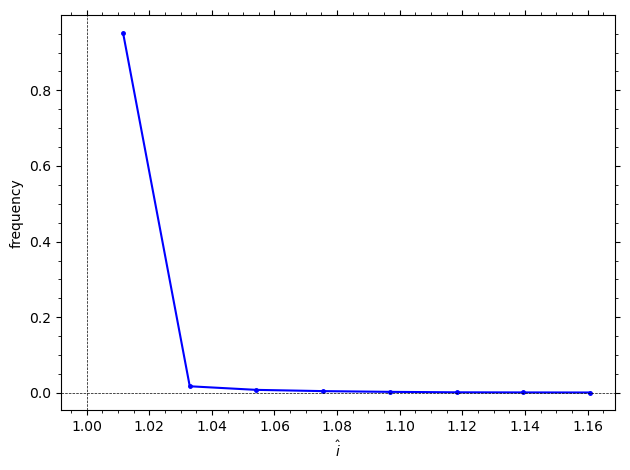

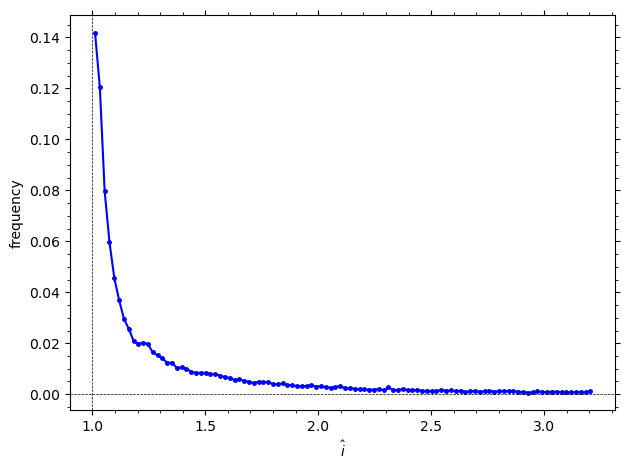

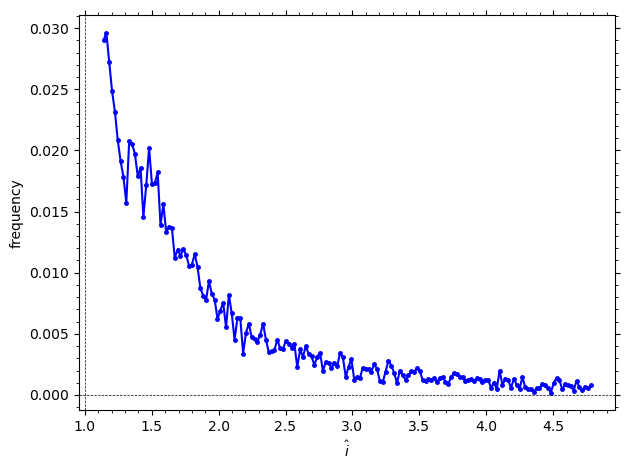

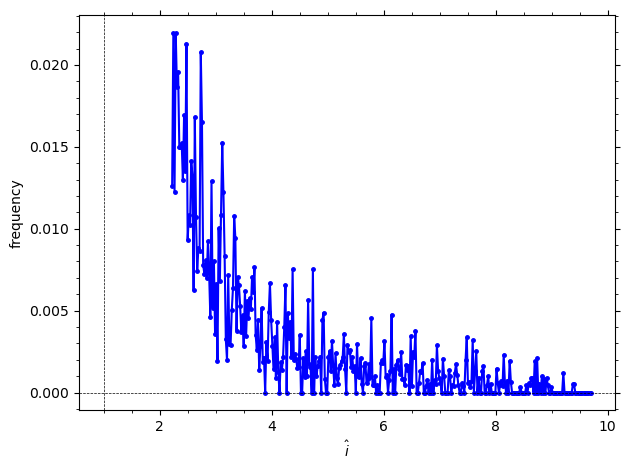

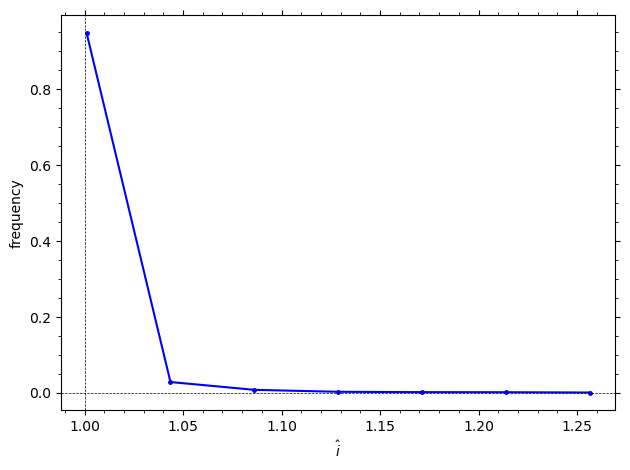

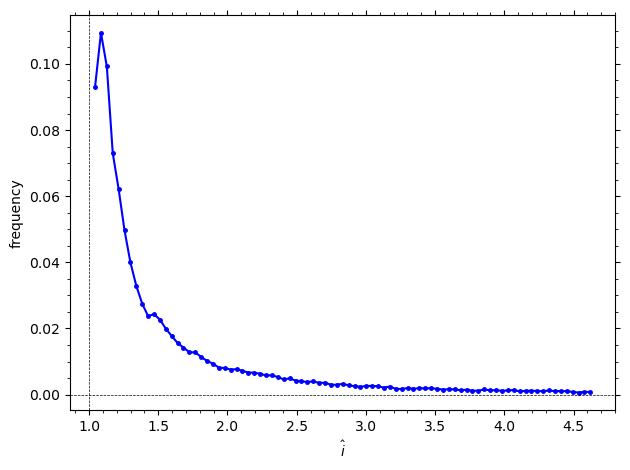

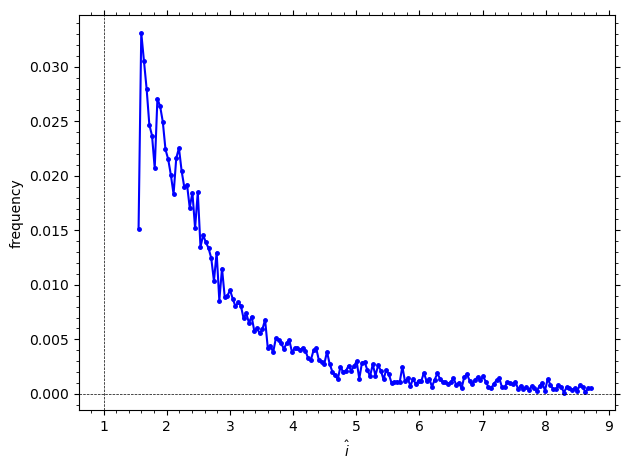

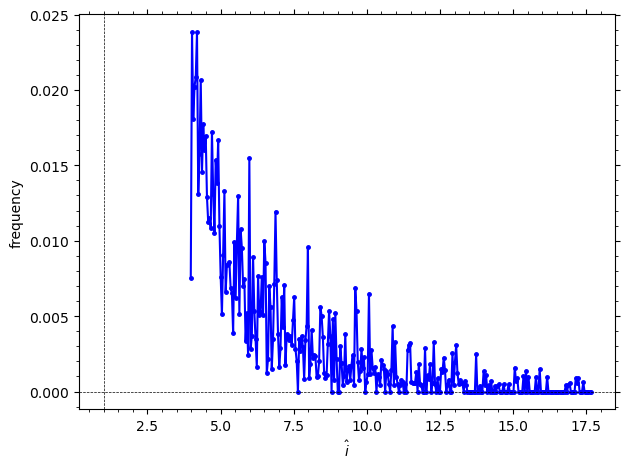

In [11]:
for dimensions in DIMENSIONS:
    for img_id in IMAGE_IDS:
        try:
            make_plot_left(name_of_study, dimensions, resolution=1, img_id=img_id, eps=None)
        except FileNotFoundError:
            print(f"No file for {dimensions}")

No file for 470-470-5


/tmp/ipykernel_413692/3485382595.py:103: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()


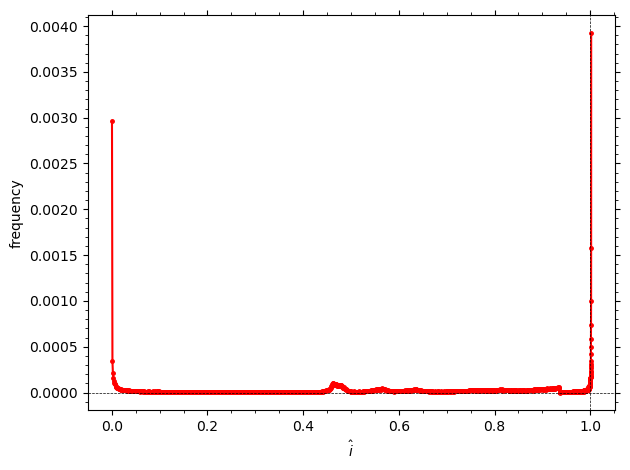

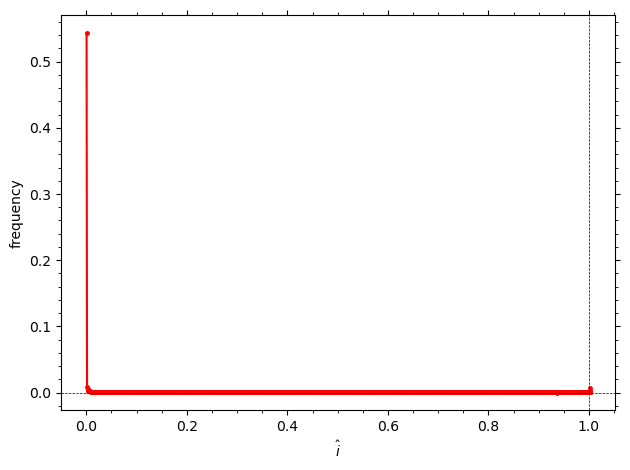

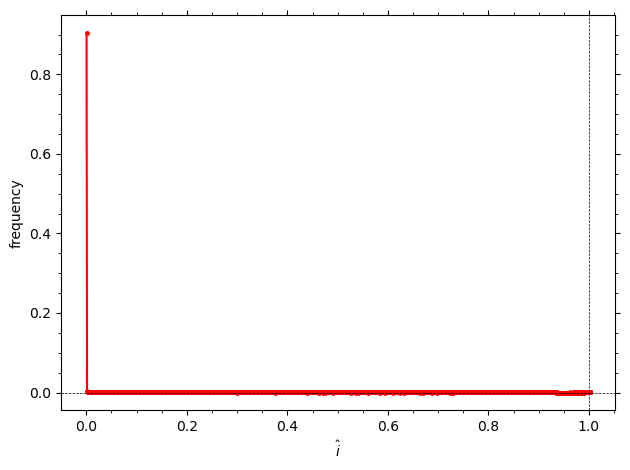

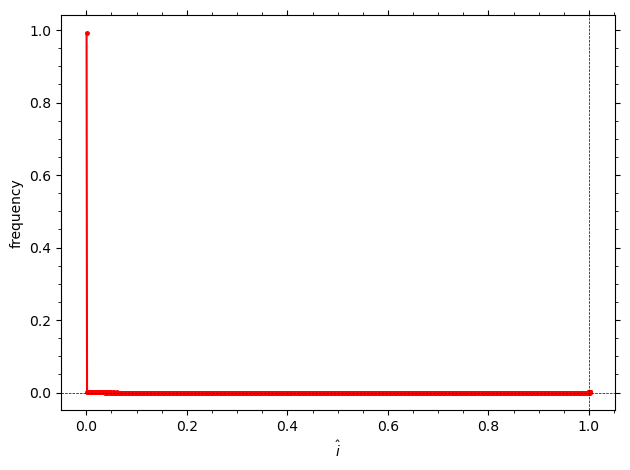

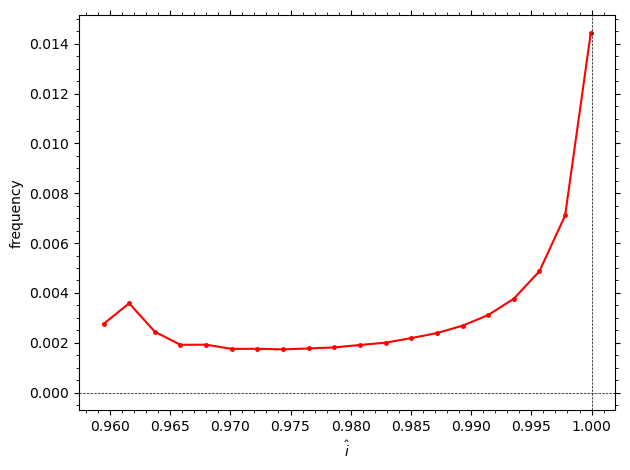

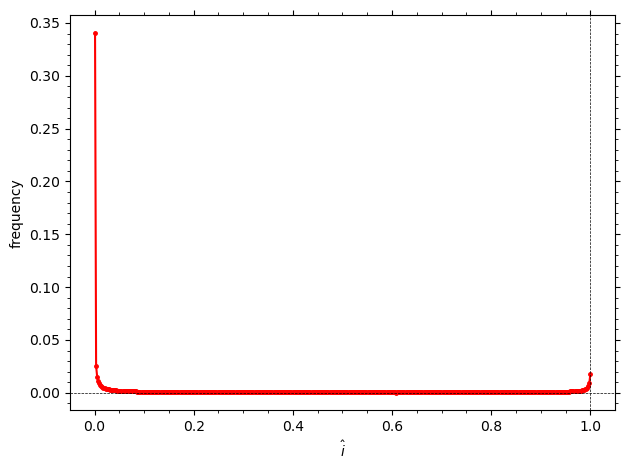

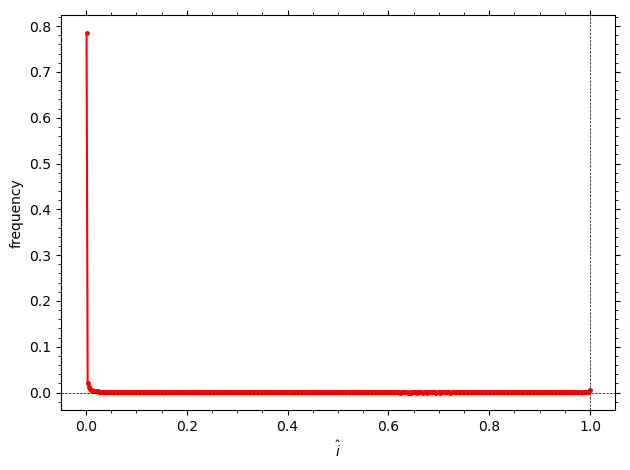

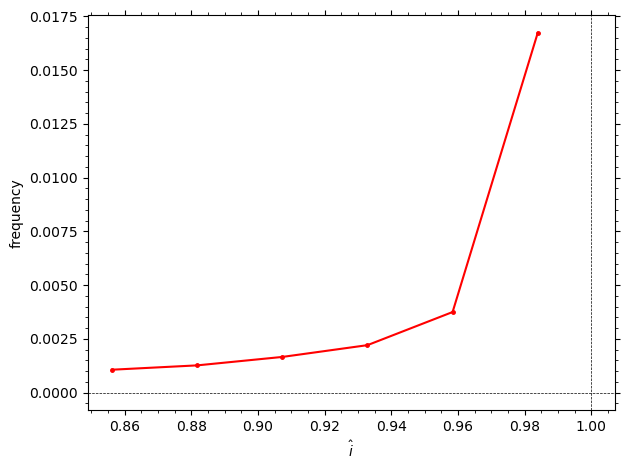

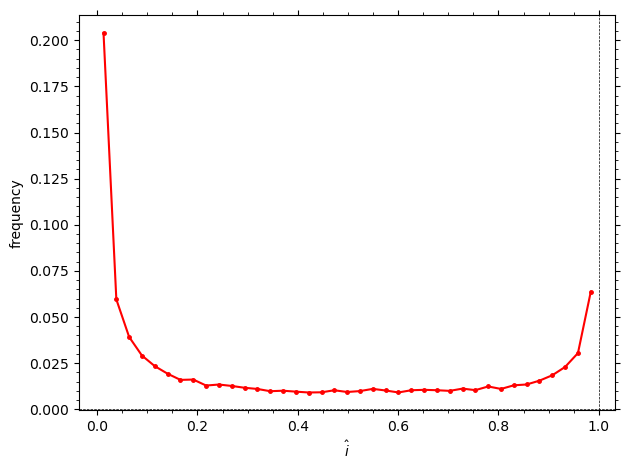

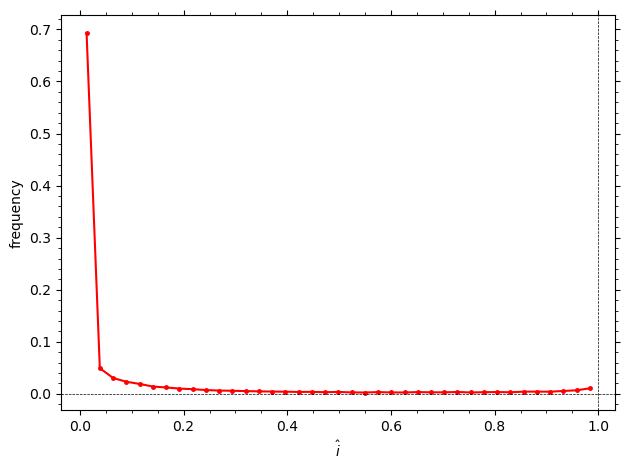

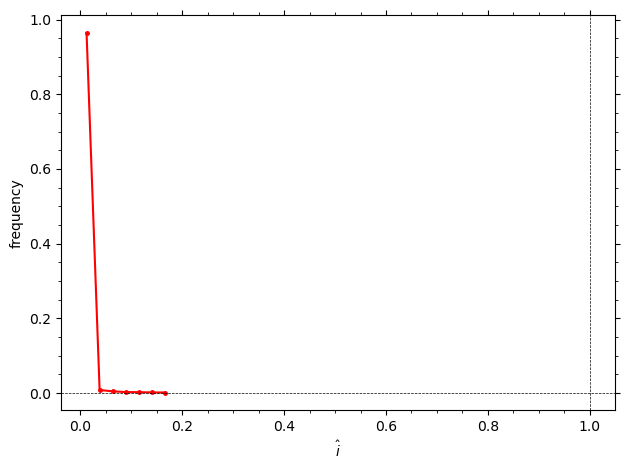

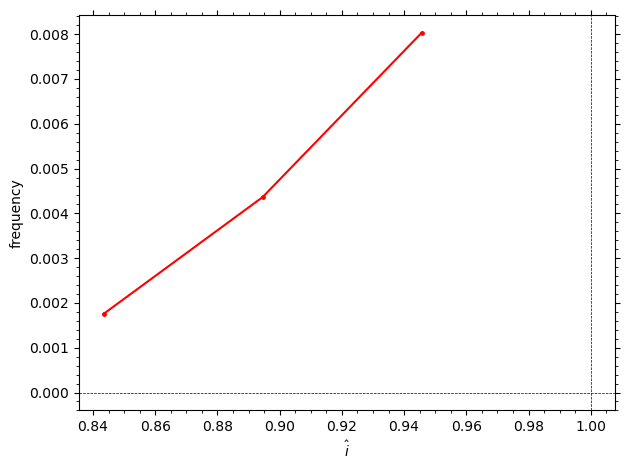

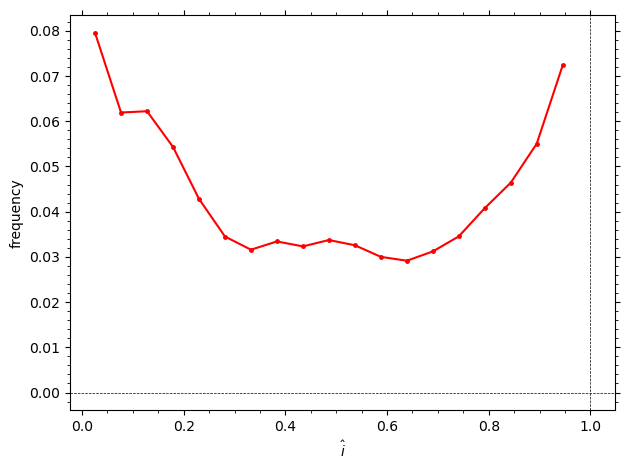

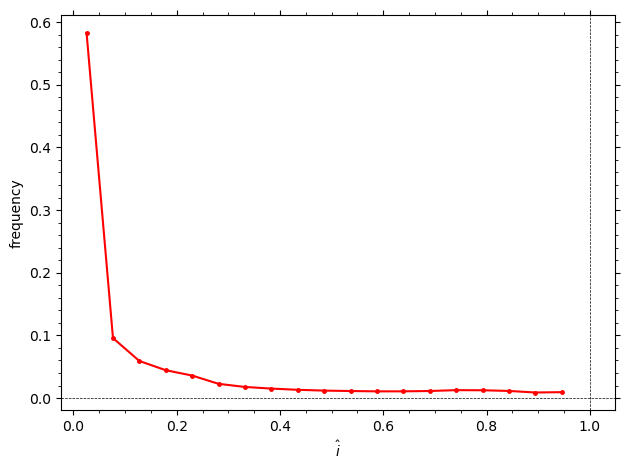

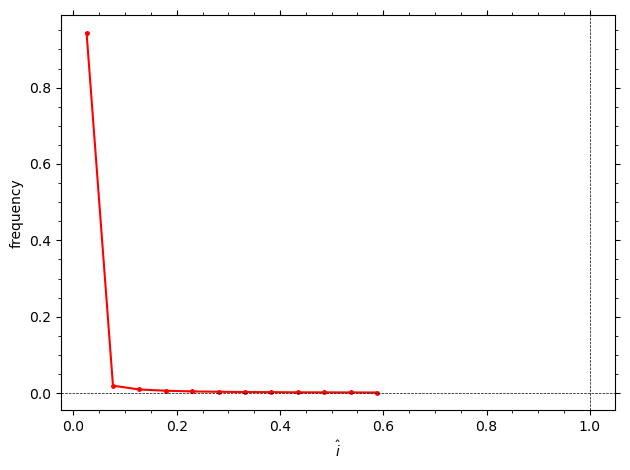

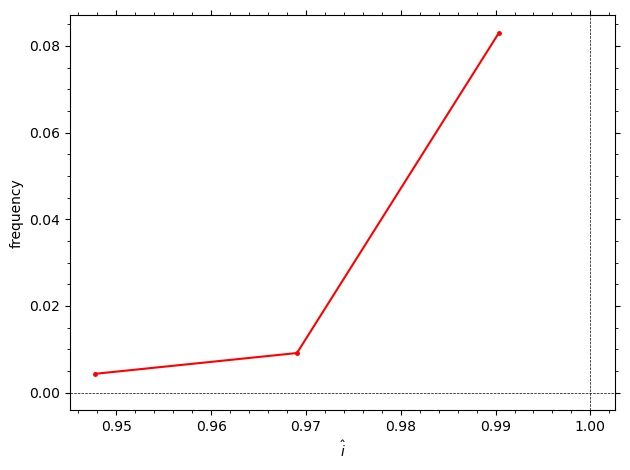

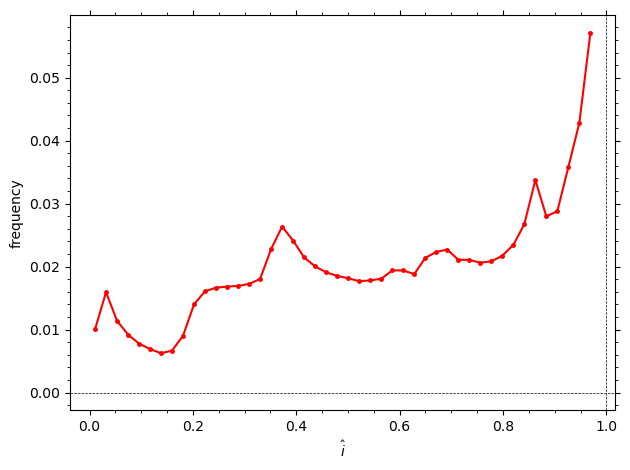

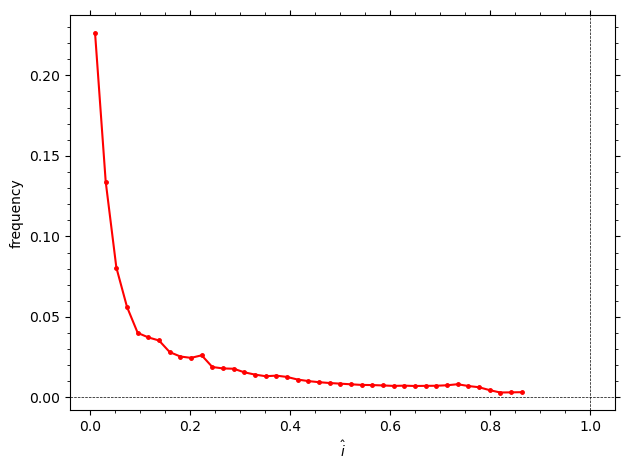

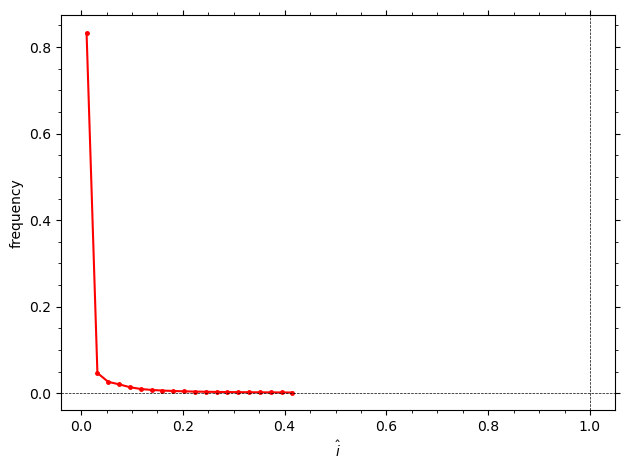

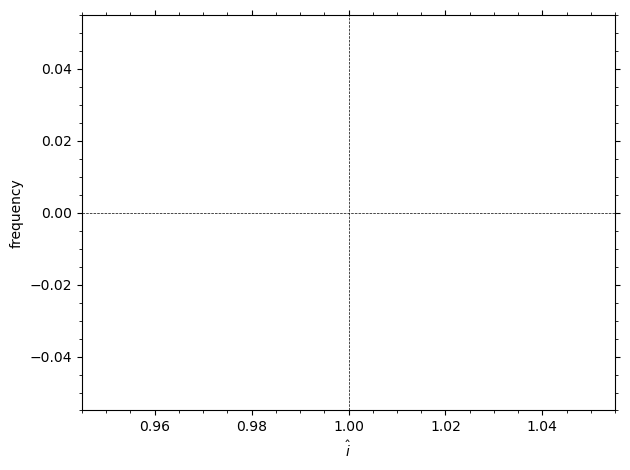

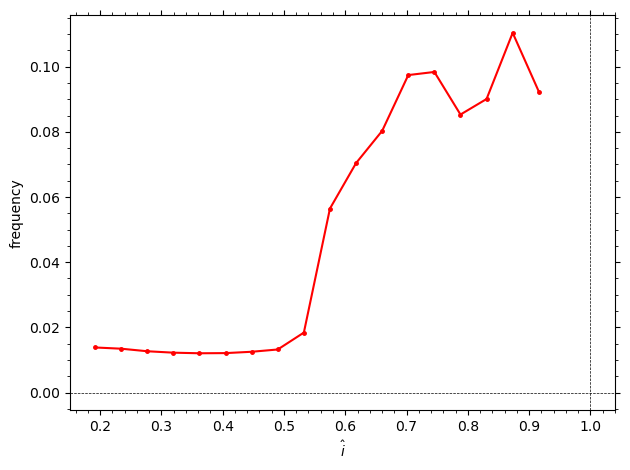

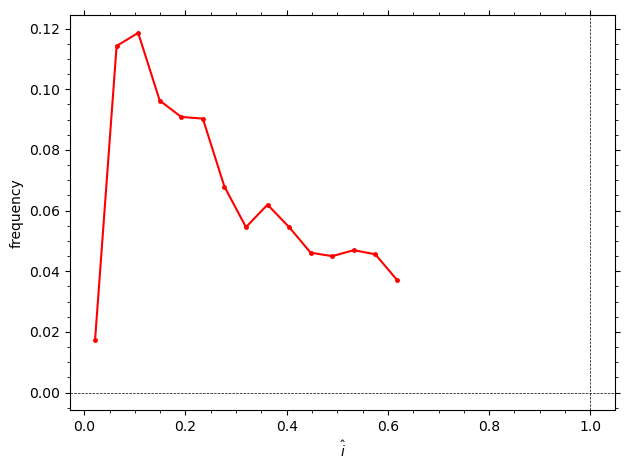

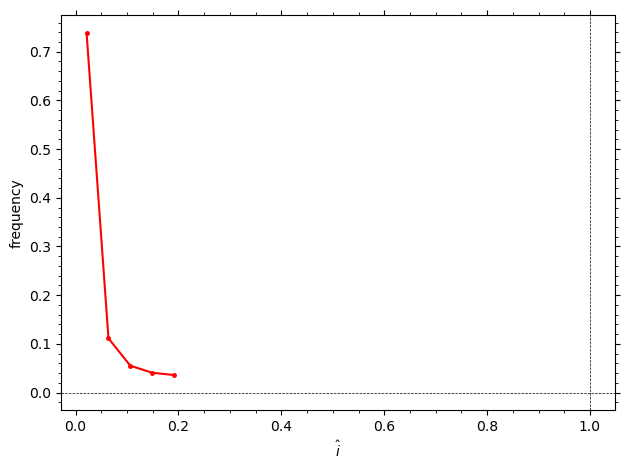

In [12]:
for dimensions in DIMENSIONS:
    Lz = int(dimensions.split("-")[2])
    for img_id in IMAGE_IDS:
        try:
            make_plot_right(name_of_study, dimensions, resolution=1, img_id=img_id, eps=None)
        except FileNotFoundError:
            print(f"No file for {dimensions}")

## Contact Loss Reference

File not found for 470-470-1 and area fraction 0.01[Errno 2] No such file or directory: 'output/contact_loss_ref/0.01/470-470-1/1/frequency.csv'
File not found for 470-470-15 and area fraction 0.01index 9999 is out of bounds for axis 0 with size 9999
File not found for 470-470-30 and area fraction 0.01index 9999 is out of bounds for axis 0 with size 9999
File not found for 470-470-50 and area fraction 0.01index 9999 is out of bounds for axis 0 with size 9999
File not found for 470-470-100 and area fraction 0.01[Errno 2] No such file or directory: 'output/contact_loss_ref/0.01/470-470-100/2/frequency.csv'


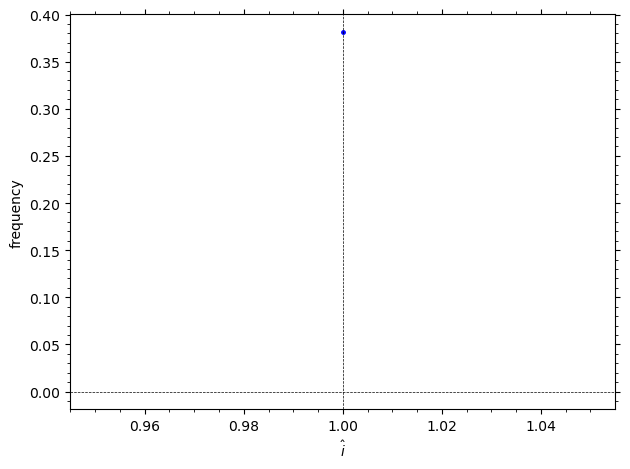

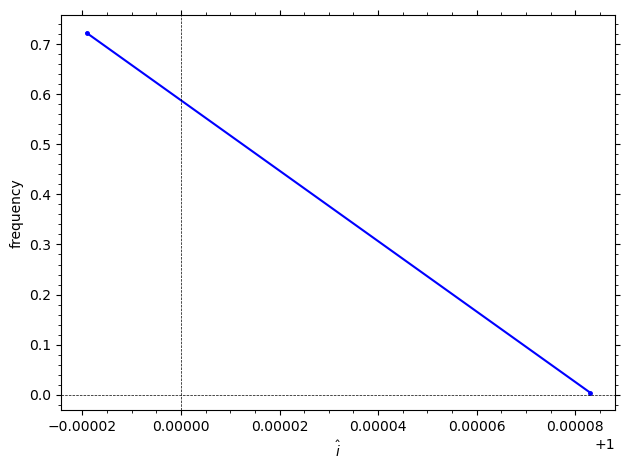

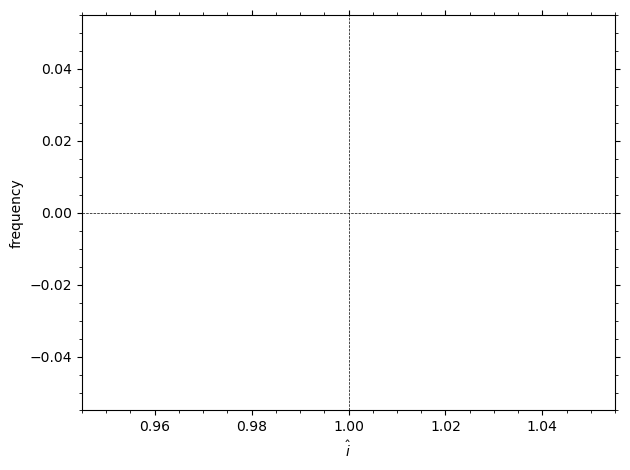

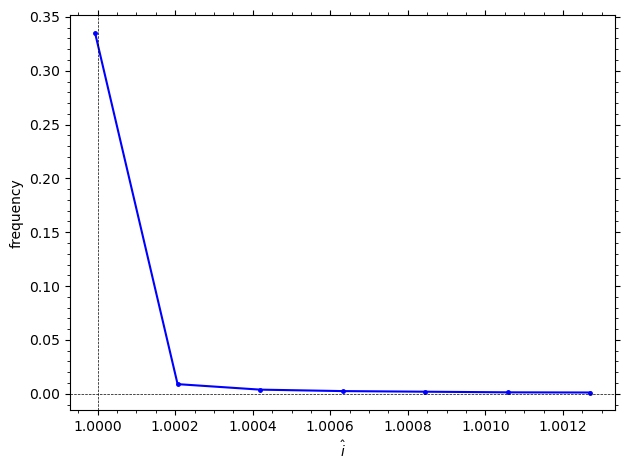

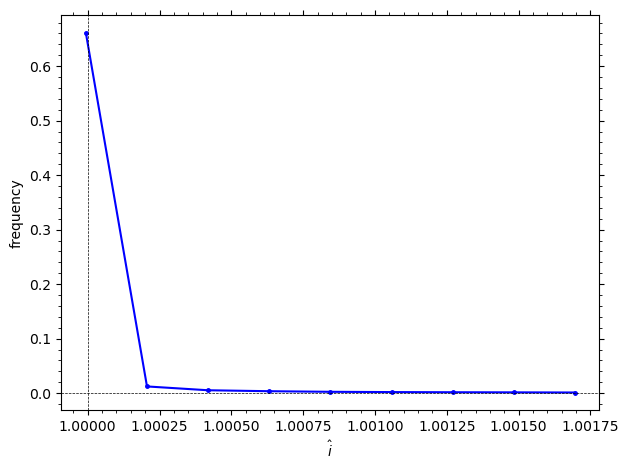

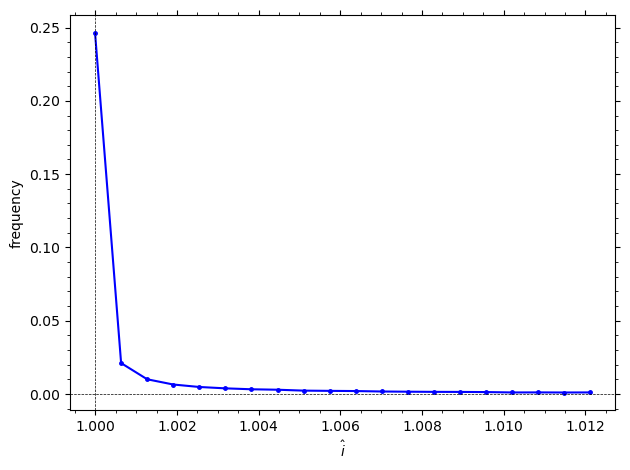

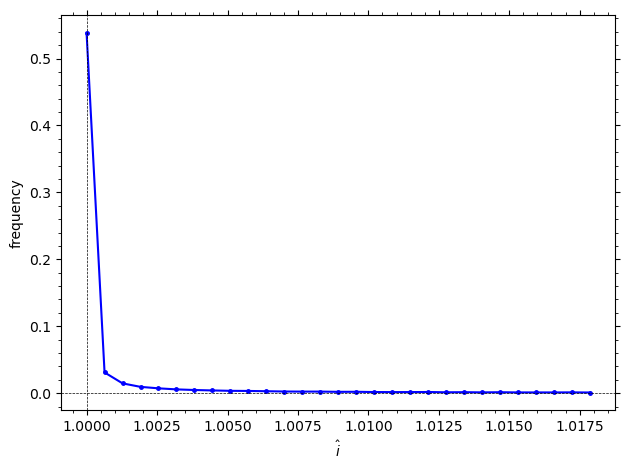

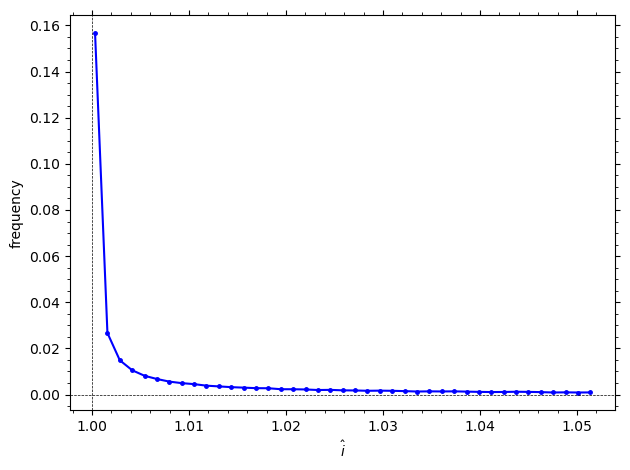

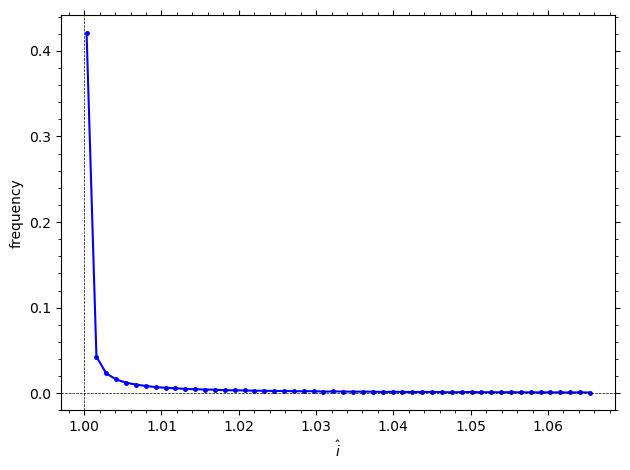

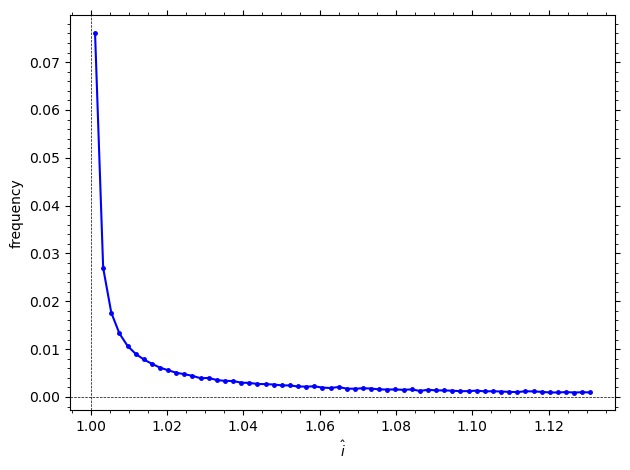

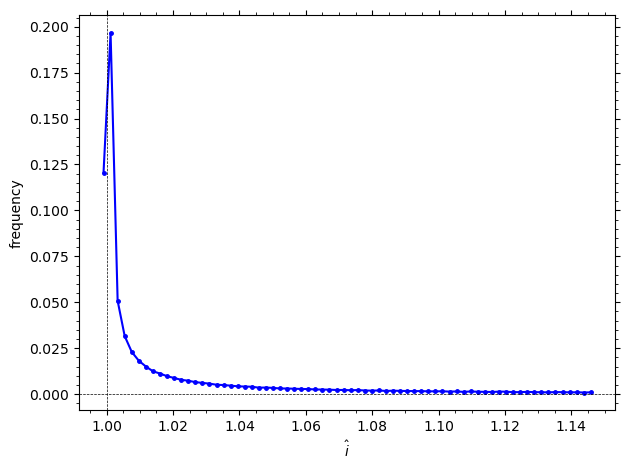

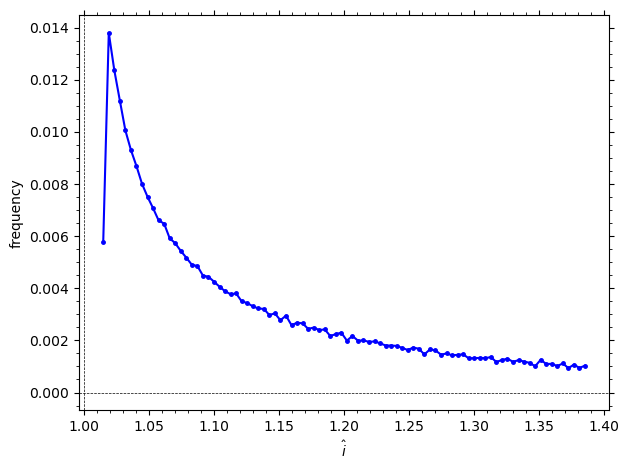

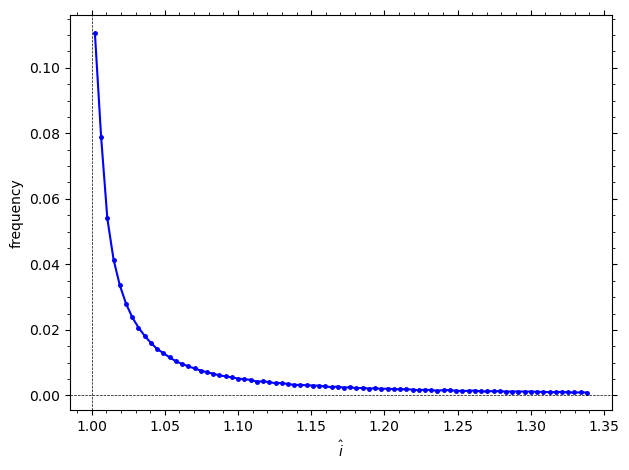

In [15]:
name_of_study = 'contact_loss_ref'

utils.make_dir_if_missing(f'figures/{name_of_study}')

for dimensions in DIMENSIONS:
    for eps in AREA_FRACTIONS:
        if np.isclose(eps, 0.01) and dimensions.split('-')[2] == '1':
            resolution = 1
        else:
            resolution = 2
        # if not os.path.exists(get_folder_path(name_of_study, dimensions, resolution=resolution, img_id=None, eps=eps)):
        #     print(f"File not found for {dimensions} and area fraction {eps}")
        #     continue
        try:
            make_plot_left(name_of_study, dimensions, resolution=resolution, img_id=None, eps=eps)
        except Exception as e:
            print(f"File not found for {dimensions} and area fraction {eps}" + str(e))
            continue

No file for 470-470-100 and eps 0.01[Errno 2] No such file or directory: 'output/contact_loss_ref/0.01/470-470-100/2/frequency.csv'


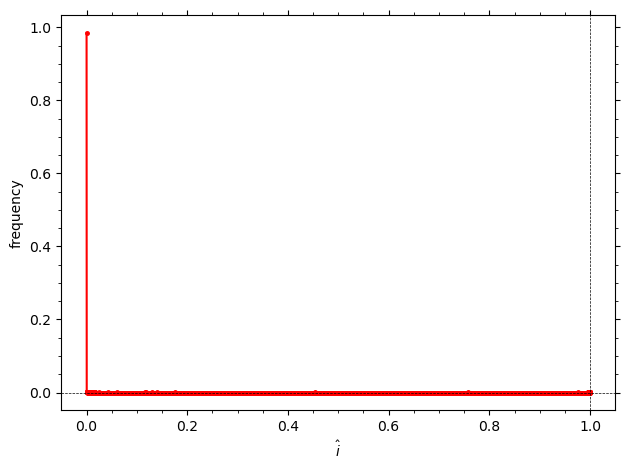

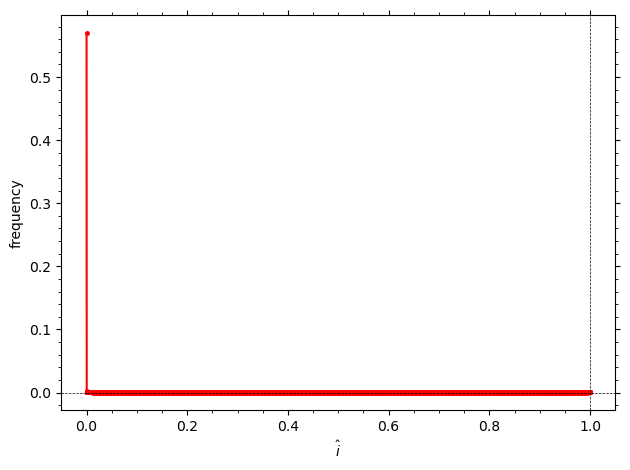

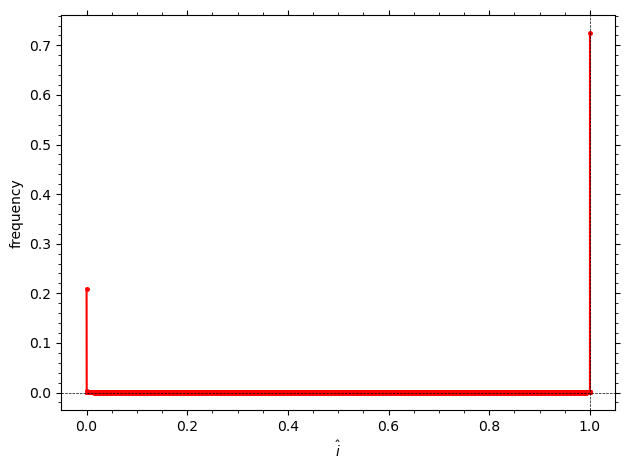

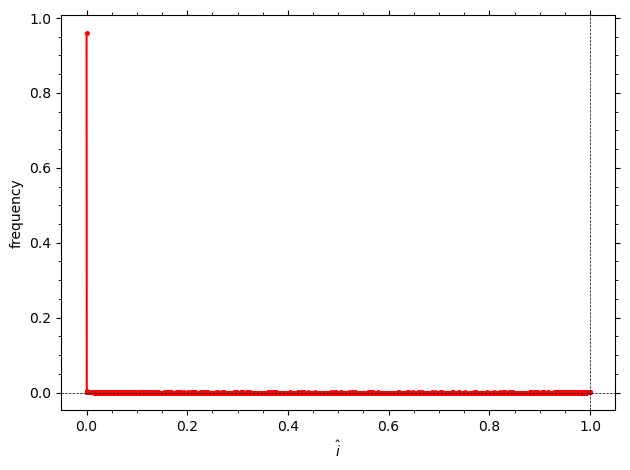

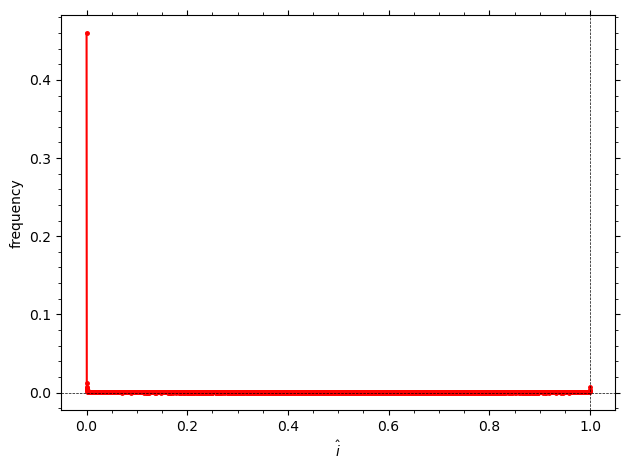

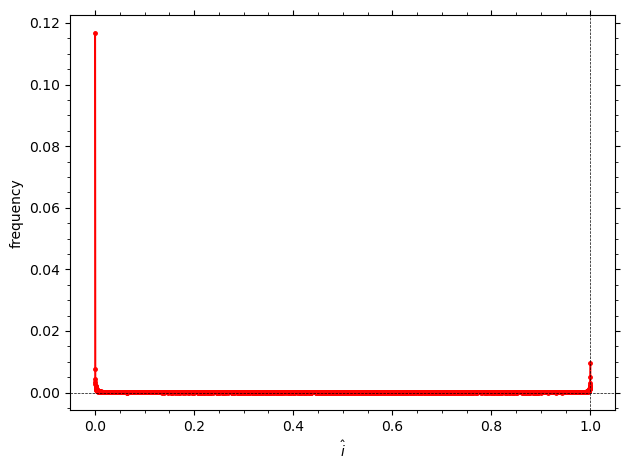

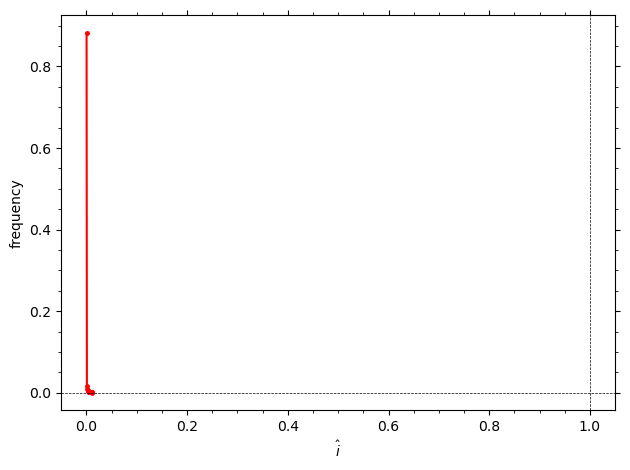

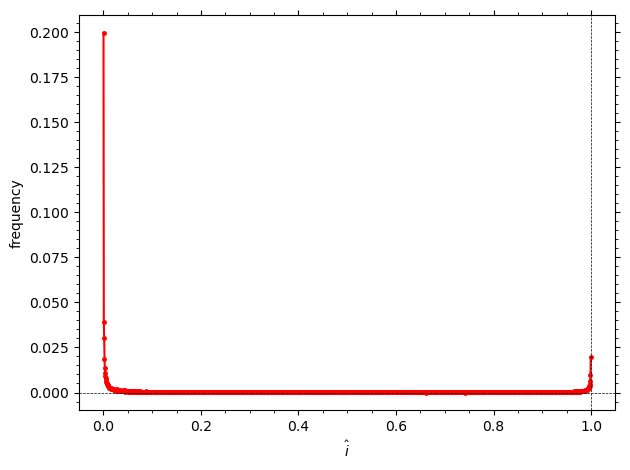

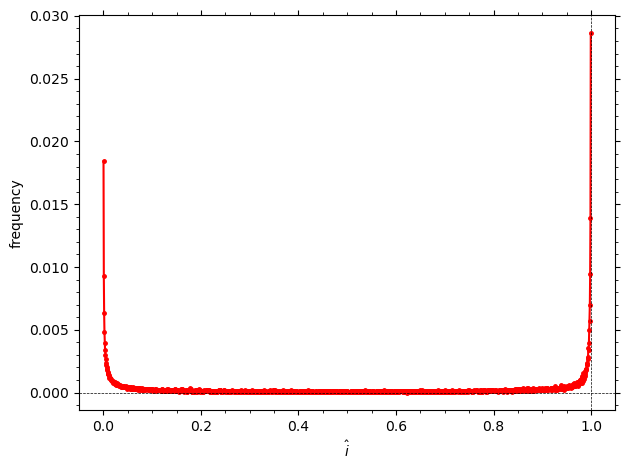

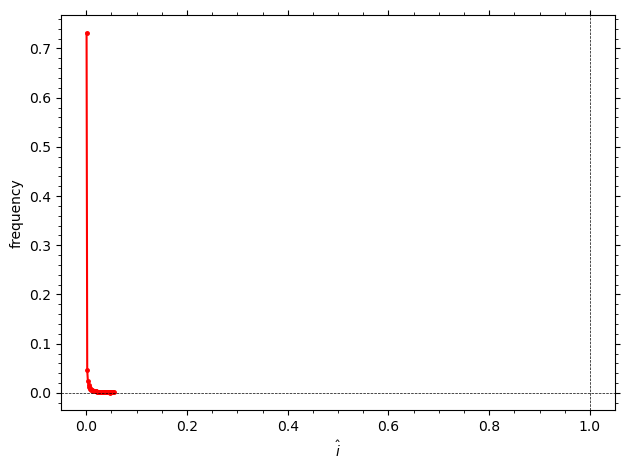

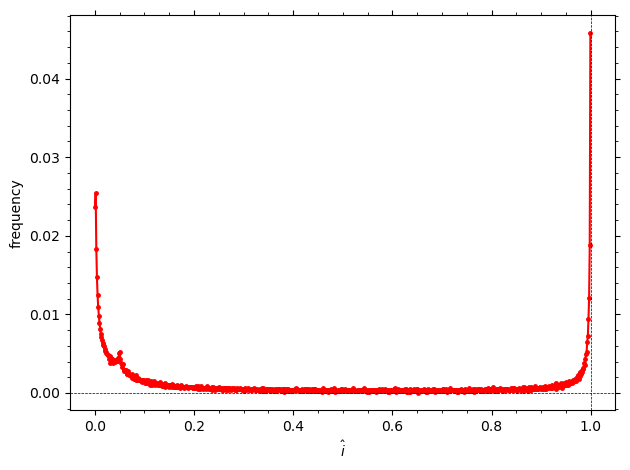

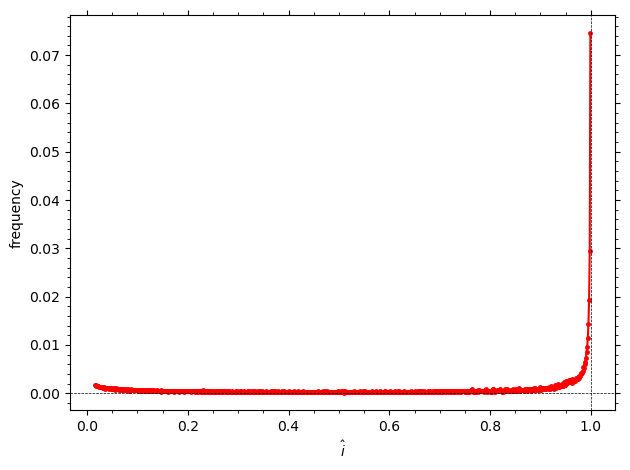

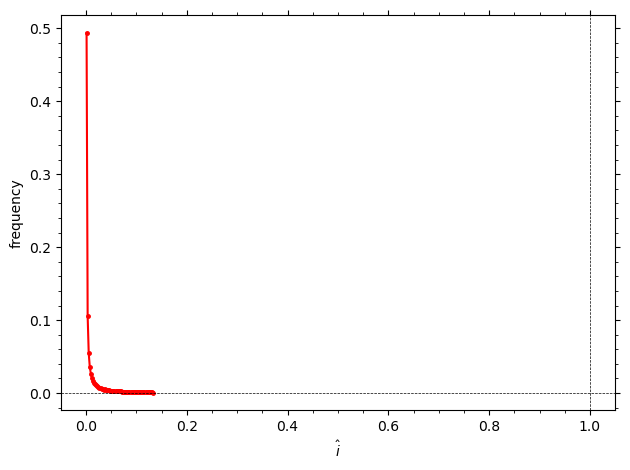

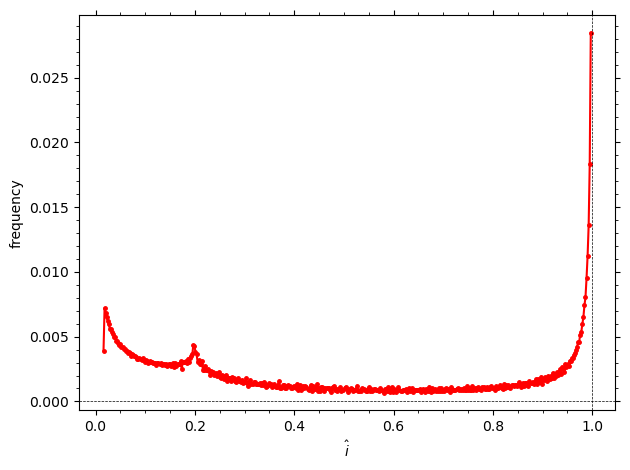

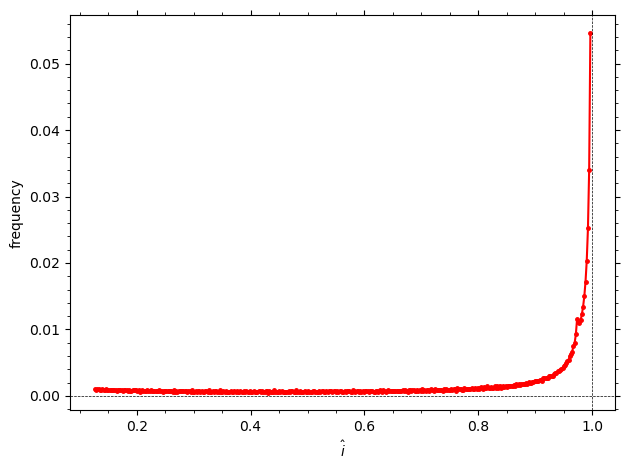

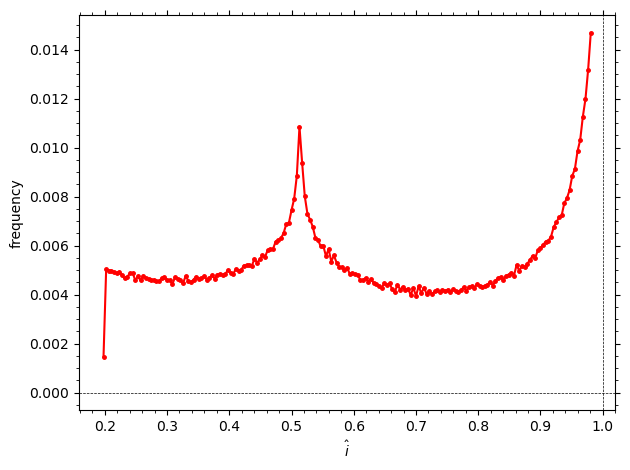

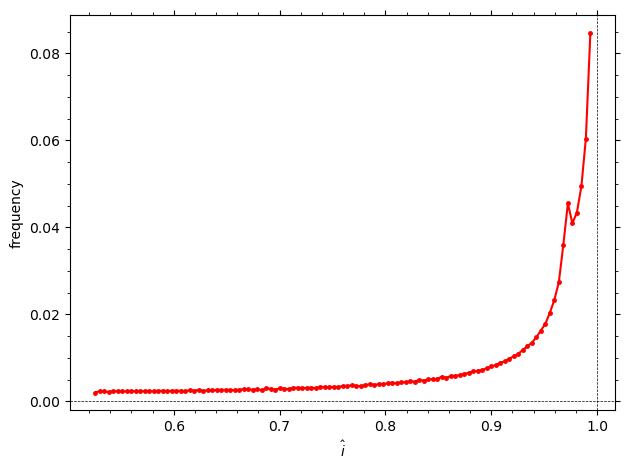

In [16]:
for dimensions in DIMENSIONS:
    for eps in AREA_FRACTIONS:
        if np.isclose(eps, 0.01) and dimensions.split('-')[2] == '1':
            resolution = 1
        else:
            resolution = 2
        # if not os.path.exists(get_folder_path(name_of_study, dimensions, resolution=2, img_id=None, eps=eps)):
        #     print(f"No file for {dimensions} and eps {eps}")
        #     continue
        try:
            make_plot_right(name_of_study, dimensions, resolution=2, img_id=None, eps=eps)
        except Exception as e:
            print(f"No file for {dimensions} and eps {eps}" + str(e))
            continue

In [18]:
moments_data = []
styles = ['k-', 'r-', 'b-', 'r-.', 'b-.', 'g-', 'r--', 'b--', 'k-.']
for eps in AREA_FRACTIONS:
    # fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    # fig.suptitle(r'$\frac{A}{A_0}$' + f' = {eps*100:.1f}%')
    for idx, dimensions in enumerate(['470-470-' + str(v) for v in [1, 15, 30, 100]]):
        Lz = int(dimensions.split("-")[2])
        # try:
        # if not os.path.exists(get_folder_path(name_of_study, dimensions, resolution=2, img_id=None, eps=eps)):
        #     print(f"File not found for {dimensions} and area fraction {eps}")
        #     continue
        try:
            stats, final = moments(name_of_study, dimensions, resolution=2, img_id=None, eps=eps)
        except Exception as e:
            print(f"File not found for {dimensions} and area fraction {eps}" + str(e))
            continue
        mu_left = stats['mu_left']
        sd_left = stats['sd_left']
        mu_right = stats['mu_right']
        sd_right = stats['sd_right']
        z_left = (final[:, 0] - mu_left) / sd_left
        z_right = (final[:, 0] - mu_right) / sd_right
        moments_data.append((Lz, eps, mu_left, sd_left, mu_right, sd_right))
#         ax[0].plot(z_left, final[:, 1], styles[idx], label=f'{Lz*800/470:.1f}' + r' $\mu m$')
#         ax[1].plot(z_right, final[:, 2], styles[idx], label=f'{Lz*800/470:.1f}' + r' $\mu m$')
   
#     ax[0].grid(True, which='both');
#     ax[0].minorticks_on();
#     ax[1].grid(True, which='both');
#     ax[1].minorticks_on();
#     ax[0].set_xlabel(r'$\frac{i-\mu_i}{\sigma_i}$', fontsize='xx-large')
#     ax[1].set_xlabel(r'$\frac{i-\mu_i}{\sigma_i}$', fontsize='xx-large')
#     ax[0].set_ylabel('frequency')
#     ax[1].set_ylabel('frequency')
#     # fig.legend(['left', 'right'])
#     ax[0].legend();
#     ax[1].legend();
#     # ax[0].set_yscale('log');
#     # ax[1].set_yscale('log');
#     ax[0].set_xlim([0, 15])
#     ax[1].set_xlim([0, 5])
#     plt.tight_layout();
#     plt.savefig(f'figures/{name_of_study}/current-density-moments-image-{eps}.png', dpi=1500);

File not found for 470-470-100 and area fraction 0.01[Errno 2] No such file or directory: 'output/contact_loss_ref/0.01/470-470-100/2/frequency.csv'


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


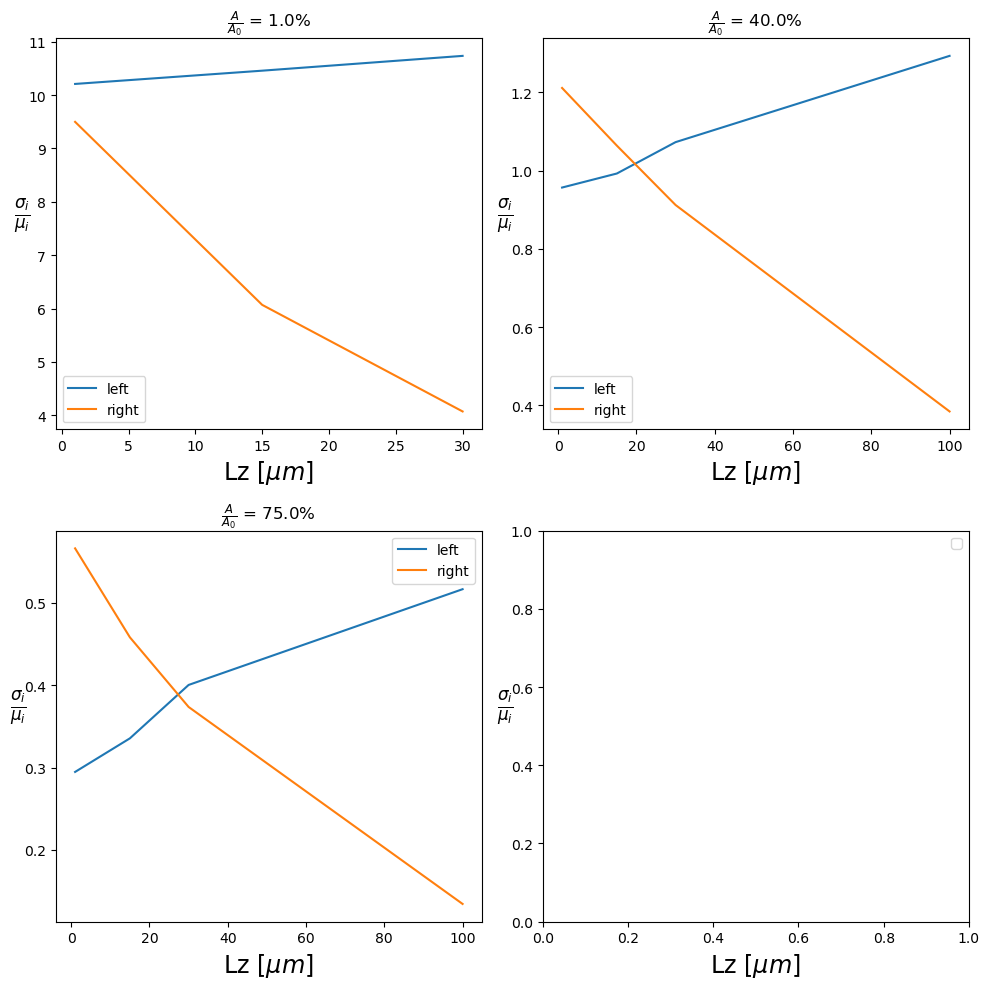

In [20]:
df_new = pd.DataFrame(moments_data, columns=['Lz', 'img_id', 'mu_left', 'sd_left', 'mu_right', 'sd_right'])
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
for idx, eps in enumerate(AREA_FRACTIONS):
    rows = np.isclose(df_new['img_id'].to_numpy(dtype=float).reshape(-1, 1), eps)
    df_new2 = df_new.loc[rows, :].to_numpy()
    if idx == 0:
        ax[0, 0].plot(df_new2[:, 0], df_new2[:, 3] / df_new2[:, 2], label='left')
        ax[0, 0].plot(df_new2[:, 0], df_new2[:, 5] / df_new2[:, 4], label='right')
        ax[0, 0].set_title(r'$\frac{A}{A_0}$ = ' + f'{eps*100:.1f}%')
    elif idx == 1:
        ax[0, 1].plot(df_new2[:, 0], df_new2[:, 3] / df_new2[:, 2], label='left')
        ax[0, 1].plot(df_new2[:, 0], df_new2[:, 5] / df_new2[:, 4], label='right')
        ax[0, 1].set_title(r'$\frac{A}{A_0}$ = ' + f'{eps*100:.1f}%')
    elif idx == 2:
        ax[1, 0].plot(df_new2[:, 0], df_new2[:, 3] / df_new2[:, 2], label='left')
        ax[1, 0].plot(df_new2[:, 0], df_new2[:, 5] / df_new2[:, 4], label='right')
        ax[1, 0].set_title(r'$\frac{A}{A_0}$ = ' + f'{eps*100:.1f}%')
    elif idx == 3:
        ax[1, 1].plot(df_new2[:, 0], df_new2[:, 3] / df_new2[:, 2], label='left')
        ax[1, 1].plot(df_new2[:, 0], df_new2[:, 5] / df_new2[:, 4], label='right')
        ax[1, 1].set_title(r'$\frac{A}{A_0}$ = ' + f'{eps*100:.1f}%')
    else:
        continue
ax[0, 0].set_xlabel('Lz [' + r'$\mu m$]', fontsize='xx-large')
ax[0, 1].set_xlabel('Lz [' + r'$\mu m$]', fontsize='xx-large')
ax[1, 0].set_xlabel('Lz [' + r'$\mu m$]', fontsize='xx-large')
ax[1, 1].set_xlabel('Lz [' + r'$\mu m$]', fontsize='xx-large')

ax[0, 0].set_ylabel(r'$\frac{\sigma_i}{\mu_i}$', fontsize='xx-large', rotation='horizontal')
ax[0, 1].set_ylabel(r'$\frac{\sigma_i}{\mu_i}$', fontsize='xx-large', rotation='horizontal')
ax[1, 0].set_ylabel(r'$\frac{\sigma_i}{\mu_i}$', fontsize='xx-large', rotation='horizontal')
ax[1, 1].set_ylabel(r'$\frac{\sigma_i}{\mu_i}$', fontsize='xx-large', rotation='horizontal')

ax[0, 0].legend()
ax[1, 0].legend()
ax[0, 1].legend()
ax[1, 1].legend()
plt.tight_layout()
plt.savefig(f'figures/{name_of_study}/current-density-moments.png')